## Assignment 2 – Practical Deep Learning Workshop - Category Embeddings

Roman Tsirulnikov 317312296

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from keras.layers import *
from keras.regularizers import l2
from keras.models import Model
from numpy import array
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K

Using TensorFlow backend.


In [2]:
# K.tensorflow_backend._get_available_gpus()

### Question 3

b.

In [3]:
items_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
shops_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
cats_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test  = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')

In [4]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
train.shape

(2935849, 6)

Filtering shops and items that are not in test set:

In [6]:
shop_ids = test['shop_id'].unique()
item_ids = test['item_id'].unique()

In [7]:
filtered_train = train[train['shop_id'].isin(shop_ids)]
filtered_train = filtered_train[filtered_train['item_id'].isin(item_ids)]

In [8]:
print(filtered_train.shape)
filtered_train.head()

(1224439, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0
12,07.01.2013,0,25,2574,399.0,1.0
13,08.01.2013,0,25,2574,399.0,2.0


I will not use "date" and "price" for training.

In [9]:
del filtered_train['date']
price_series = filtered_train[['item_price', 'item_id']].drop_duplicates(subset='item_id')
del filtered_train['item_price']

In [10]:
filtered_train.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
10,0,25,2574,2.0
11,0,25,2574,1.0
12,0,25,2574,1.0
13,0,25,2574,2.0


Creating a table that presenting total sales per shop, item and month.

In [11]:
train_df = filtered_train.groupby(['shop_id', 'item_id', 'date_block_num']).sum().reset_index()
train_df = train_df.rename(columns={'item_cnt_day': 'total_sales'}).sort_values(by = ['date_block_num', 'item_id', 'shop_id'])
train_df.head()

,shop_id,item_id,date_block_num,total_sales
8187,3,32,0,3.0
17050,4,32,0,2.0
40440,6,32,0,8.0
60342,7,32,0,1.0
92830,14,32,0,3.0


In [12]:
train_df.shape

(600159, 4)

Training classical ML algorithm to get solid benchmark.

In [13]:
clf = DecisionTreeRegressor()
clf.fit(train_df[['shop_id', 'item_id', 'date_block_num']], train_df['total_sales'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [14]:
test['date_block_num'] = [34]*len(test)
test.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


Saving the results:

In [15]:
predictions = clf.predict(test)
res_df = pd.DataFrame(predictions, columns=['item_cnt_month'])
res_df['ID'] = test.index
res_df = res_df[['ID', 'item_cnt_month']]
res_df.to_csv('solid_benchmark.csv', index=False)
res_df.head()

,ID,item_cnt_month
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0


Score from kaggle: 16.87303, Leaderboard place: 5,204

c.

In [16]:
shops = {p:i for (i,p) in enumerate(set(np.concatenate((train_df['shop_id'].unique(), test['shop_id'].unique()))))}
items = {p:i for (i,p) in enumerate(set(np.concatenate((train_df['item_id'].unique(), test['item_id'].unique()))))}
months = {p:i for (i,p) in enumerate(np.concatenate((train_df['date_block_num'].unique() ,np.array([34]))))}

In [17]:
preprocess_df = train_df.copy(deep=True)
preprocess_df['shop_id'] = [shops[i] for i in preprocess_df['shop_id']]
preprocess_df['item_id'] = [items[i] for i in preprocess_df['item_id']]
preprocess_df['date_block_num'] = [months[i] for i in preprocess_df['date_block_num']]
preprocess_df.head()

,shop_id,item_id,date_block_num,total_sales
8187,1,12,0,3.0
17050,2,12,0,2.0
40440,4,12,0,8.0
60342,5,12,0,1.0
92830,8,12,0,3.0


In [18]:
len_shop = len(shops)
len_item = len(items)
len_months = len(months)
print(f'shops: {len_shop}, items: {len_item}, month: {len_months}')

shops: 42, items: 5100, month: 35


Creating embeddings for shop id and item id.<br>
Output dimension decided by the formula: output_dim = min(50, sqrt(len(input_dim))) as presented in class.

In [19]:
shop_inp = Input(shape=(1,),dtype='int64')
item_inp = Input(shape=(1,),dtype='int64')
months_inp = Input(shape=(1,),dtype='int64')

shop_emb = Embedding(len_shop,6,input_length=1, embeddings_regularizer=l2(1e-6))(shop_inp)
item_emb = Embedding(len_item,50,input_length=1, embeddings_regularizer=l2(1e-6))(item_inp)
months_emb = Embedding(len_months,6,input_length=1, embeddings_regularizer=l2(1e-6))(months_inp)

Creating a model, using concatenate layer to concat the embeddings.

In [20]:
x = concatenate([shop_emb,item_emb, months_emb])
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1,activation='relu')(x)
nn_model = Model([shop_inp,item_inp,months_inp],x)
nn_model.compile(loss = 'mse',optimizer='adam')

In [21]:
nn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 6)         252         input_1[0][0]                    
____________________________________________________________________________________________

d.

In [22]:
history = nn_model.fit([preprocess_df['shop_id'], preprocess_df['item_id'], preprocess_df['date_block_num']] ,preprocess_df['total_sales'],epochs=10, validation_split=0.2)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 480127 samples, validate on 120032 samples
Epoch 1/10
480127/480127 [==============================] - 115s 240us/step - loss: 130.4490 - val_loss: 82.1707
Epoch 2/10
480127/480127 [==============================] - 113s 236us/step - loss: 117.8942 - val_loss: 81.3248
Epoch 3/10
480127/480127 [==============================] - 113s 235us/step - loss: 104.0434 - val_loss: 85.8560
Epoch 10/10
480127/480127 [==============================] - 113s 234us/step - loss: 102.0423 - val_loss: 85.9747


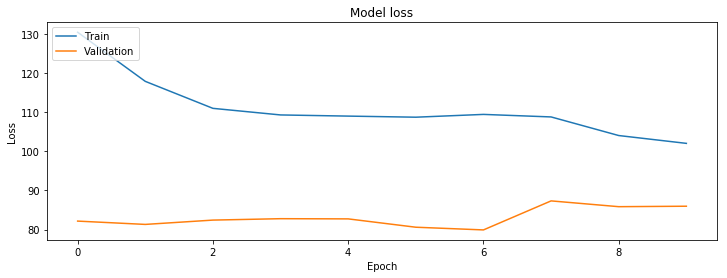

In [23]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We can see that both, train and validation losses decreased.

Next, I will test the model on the test data.

In [24]:
predictions = nn_model.predict([[shops[i] for i in test['shop_id']], [items[i] for i in test['item_id']], [months[i] for i in test['date_block_num']]])
res_df = pd.DataFrame(predictions, columns=['item_cnt_month'])
res_df['ID'] = test.index
res_df = res_df[['ID', 'item_cnt_month']]
res_df.to_csv('model_11.csv', index=False)

Kaggle score: 2.09498, Leaderboard place: 4797.<br>
There have been an improvement, I've advanced 409 places on the leaderboard!

e.

Next, I will add the features item category and item price and check how the impact the results.
I will use embedding for the category feature because it is a categorical featurte.

In [25]:
train2_df = pd.merge(train_df,items_df, on='item_id' )
train2_df = pd.merge(train2_df,price_series, on='item_id')
train2_df.head()

,shop_id,item_id,date_block_num,total_sales,item_name,item_category_id,item_price
0,3,32,0,3.0,1+1,40,349.0
1,4,32,0,2.0,1+1,40,349.0
2,6,32,0,8.0,1+1,40,349.0
3,7,32,0,1.0,1+1,40,349.0
4,14,32,0,3.0,1+1,40,349.0


In [26]:
len_cat = len(train2_df['item_category_id'].unique())
cat_inp = Input(shape=(1,),dtype='int64')
cat_emb = Embedding(len_cat,8,input_length=1, embeddings_regularizer=l2(1e-6))(cat_inp)
cats = {p:i for (i,p) in enumerate(np.concatenate((train2_df['item_category_id'].unique(), pd.merge(test, items_df, on='item_id', how = 'left')['item_category_id'].unique())))}
price_inp = Input(shape=(1,1),dtype='float32')

In [27]:
preprocess2_df = train2_df.copy(deep=True)
preprocess2_df['shop_id'] = [shops[i] for i in preprocess2_df['shop_id']]
preprocess2_df['item_id'] = [items[i] for i in preprocess2_df['item_id']]
preprocess2_df['date_block_num'] = [months[i] for i in preprocess2_df['date_block_num']]
preprocess2_df['item_category_id'] = [cats[i] for i in preprocess2_df['item_category_id']]
preprocess2_df.head()

,shop_id,item_id,date_block_num,total_sales,item_name,item_category_id,item_price
0,1,12,0,3.0,1+1,74,349.0
1,2,12,0,2.0,1+1,74,349.0
2,4,12,0,8.0,1+1,74,349.0
3,5,12,0,1.0,1+1,74,349.0
4,8,12,0,3.0,1+1,74,349.0


In [28]:
x = concatenate([shop_emb,item_emb, months_emb, cat_emb, price_inp])
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1,activation='relu')(x)
nn_model2 = Model([shop_inp, item_inp, months_inp, cat_inp, price_inp],x)
nn_model2.compile(loss = 'mse',optimizer='adam')

In [29]:
nn_model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

In [30]:
history = nn_model2.fit([preprocess2_df['shop_id'], preprocess2_df['item_id'], preprocess2_df['date_block_num'], preprocess2_df['item_category_id'], np.expand_dims(np.expand_dims(preprocess2_df['item_price'], axis=1), axis=1)] ,preprocess2_df['total_sales'],epochs=10, validation_split=0.2)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 480127 samples, validate on 120032 samples
Epoch 1/10
480127/480127 [==============================] - 121s 251us/step - loss: 130.3072 - val_loss: 49.0523
Epoch 2/10
480127/480127 [==============================] - 118s 245us/step - loss: 117.4512 - val_loss: 49.1180
Epoch 3/10
480127/480127 [==============================] - 118s 246us/step - loss: 114.7676 - val_loss: 49.0617
Epoch 4/10
480127/480127 [==============================] - 120s 250us/step - loss: 108.7910 - val_loss: 49.0361
Epoch 5/10
480127/480127 [==============================] - 120s 251us/step - loss: 104.7599 - val_loss: 48.9812
Epoch 6/10
480127/480127 [==============================] - 122s 255us/step - loss: 104.5019 - val_loss: 49.0939
Epoch 7/10
191968/480127 [==========>...................] - ETA: 1:06 - loss: 69.8605

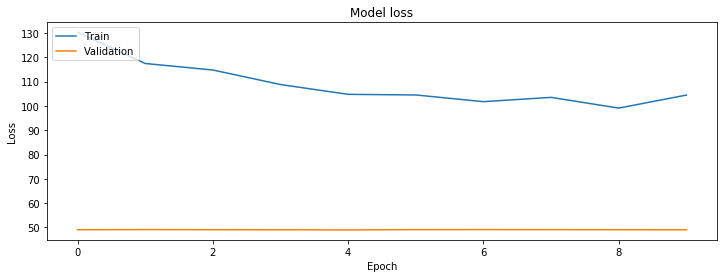

In [31]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Adding prices and categories to test items.

In [32]:
test2 = pd.merge(test, items_df, on='item_id', how = 'left')
test2 = pd.merge(test2, price_series, on='item_id',how = 'left')
test2.head()

,shop_id,item_id,date_block_num,item_name,item_category_id,item_price
0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,2599.0
1,5,5320,34,ONE DIRECTION Made In The A.M.,55,NaN
2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,1199.0
3,5,5232,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,599.5
4,5,5268,34,"Need for Speed [PS4, русская версия]",20,NaN


As we see above, not all items in the test set have price. To solve this problem I will change NaN prices to the mean price of all products.

In [33]:
test2 = test2.fillna(test2['item_price'].mean())
test2.head()

,shop_id,item_id,date_block_num,item_name,item_category_id,item_price
0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,2599.00000
1,5,5320,34,ONE DIRECTION Made In The A.M.,55,1069.57442
2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,1199.00000
3,5,5232,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,599.50000
4,5,5268,34,"Need for Speed [PS4, русская версия]",20,1069.57442


In [34]:
del test2['item_name']

In [35]:
test2.head()

,shop_id,item_id,date_block_num,item_category_id,item_price
0,5,5037,34,19,2599.00000
1,5,5320,34,55,1069.57442
2,5,5233,34,19,1199.00000
3,5,5232,34,23,599.50000
4,5,5268,34,20,1069.57442


In [36]:
test2.shape

(214200, 5)

Preprocess the test data as we did to the train.

In [37]:
p_test2 = test2.copy(deep=True)
p_test2['shop_id'] = [shops[x] for x in p_test2['shop_id']]
p_test2['item_id'] = [items[x] for x in p_test2['item_id']]
p_test2['date_block_num'] = [months[x] for x in p_test2['date_block_num']]
p_test2['item_category_id'] = [cats[x] for x in p_test2['item_category_id']]


In [38]:
p_test2.shape

(214200, 5)

Next, I will test the model on the test data.

In [39]:
predictions = nn_model2.predict([p_test2['shop_id'], p_test2['item_id'], p_test2['date_block_num'], p_test2['item_category_id'], np.expand_dims(np.expand_dims(p_test2['item_price'], axis=1), axis=1)])
res_df = pd.DataFrame(predictions, columns=['item_cnt_month'])
res_df['ID'] = test2.index
res_df = res_df[['ID', 'item_cnt_month']]
res_df.to_csv('model_2.csv', index=False)

Kaggle score: 21.98420, worse than our benchmark results.<br>
The validation loss was not changing at all during the learning process, the model was not able to learn.

f. Adding more feature not always will help the model learn as I received above.

g.

I will use the model from 3d for feature axtraction because it provided better results.

Extracting features using the embedding layer I created in 3d.

In [40]:
feature_extractor = Model(inputs=nn_model.input,outputs=nn_model.layers[6].output)
train_features = feature_extractor.predict([preprocess_df['shop_id'], preprocess_df['item_id'], preprocess_df['date_block_num']])
test_features = feature_extractor.predict([[shops[i] for i in test['shop_id']], [items[i] for i in test['item_id']], [months[i] for i in test['date_block_num']]])
train_features = np.squeeze(train_features) # remove dimension of 1
test_features = np.squeeze(test_features)

Training a Linear regression model on the embeddings features.

In [41]:
reg = LinearRegression().fit(train_features, preprocess_df['total_sales'])
pred = reg.predict(test_features)

saving the results:

In [42]:
res_df = pd.DataFrame(pred, columns=['item_cnt_month'])
res_df['ID'] = test2.index
res_df = res_df[['ID', 'item_cnt_month']]
res_df.to_csv('model_3.csv', index=False)

Kaggle score is: 2.93028. Much better whan the previous model in 3e but worse than the first model in 3d.